**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2023*

----

# Trabajo práctico entregable - parte 1

En esta notebook, vamos a cargar el conjunto de datos de [la compentencia Kaggle](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot) sobre estimación de precios de ventas de propiedades en Melbourne, Australia.

Utilizaremos el conjunto de datos reducido producido por [DanB](https://www.kaggle.com/dansbecker). Hemos subido una copia a un servidor de la Universidad Nacional de Córdoba para facilitar su acceso remoto.

In [ ]:
import matplotlib.pyplot as plt
import numpy
import pandas
import plotly
import seaborn as sns
sns.set_context('talk')

from sqlalchemy import create_engine, text

## Ejercicio 1 SQL:

1. Crear una base de datos en SQLite utilizando la libreria [SQLalchemy](https://stackoverflow.com/questions/2268050/execute-sql-from-file-in-sqlalchemy).
https://docs.sqlalchemy.org/en/14/core/engines.html#sqlite


In [ ]:
engine = create_engine('sqlite:///melbourne_prop.sqlite3') #creamos el database en SQLite


2. Ingestar los datos provistos en 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv' en una tabla y el dataset generado en clase con datos de airbnb y sus precios por codigo postal en otra.


In [ ]:
melb_df = pandas.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv')
melb_df.to_sql('kaggle', con=engine, if_exists="replace") #ingestamos los datos del dataframe de Kaggle  de Pandas en SQLite

13580

In [ ]:
interesting_cols = [
  'description', 'neighborhood_overview',
  'street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode',
  'price', 'weekly_price', 'monthly_price',
  'latitude', 'longitude']
airbnb_df = pandas.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv',
    usecols=interesting_cols)

<ipython-input-4-c8296bac228d>:6: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  airbnb_df = pandas.read_csv(


In [ ]:
airbnb_df.to_sql('airbnb', con=engine, if_exists="replace") #ingestamos los datos del dataframe de Airbnb de Pandas en SQLite

22895

3. Implementar consultas en SQL que respondan con la siguiente información:

    - cantidad de registros totales por ciudad.
    - cantidad de registros totales por barrio y ciudad.


El primer paso que realizaremos es una exploración de datos. Necesitamos columnas de barrio y ciudad.

In [ ]:
melb_df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

En melb_df a diferencia de airbnb_df no existen las columnas solicitadas. Sin embargo, podemos ver si existe intersección con columnas que son semejantes. Tomaremos CouncilArea para City y Suburb para neighborhood

In [ ]:
airbnb_df.city.values

array(['Manningham', 'Moreland', 'Port Phillip', ..., 'Monash',
       'Melbourne', 'Melbourne'], dtype=object)

In [ ]:
melb_df.CouncilArea.dropna().values

array(['Yarra', 'Yarra', 'Yarra', ..., 'Whittlesea', 'Maribyrnong',
       'Maribyrnong'], dtype=object)

In [ ]:
intersection = numpy.intersect1d(
    airbnb_df.city.values, melb_df.CouncilArea.dropna().values, assume_unique=False)
print("Airbnb unique city", len(airbnb_df.city.unique()))
print("Melb unique CouncilArea", len(melb_df.CouncilArea.unique()))
print("Common cities", len(intersection))

Airbnb unique city 30
Melb unique CouncilArea 34
Common cities 30


El resultado de la intersección es favorable por lo que al momento de hacer las consultas SQL utilizaremos la columna CouncilArea como semejante a city para melb_df.
Continuamos explorando que sucede respecto a neighborhood...

In [ ]:
airbnb_df.neighborhood.dropna().values

array(['Balwyn North', 'Brunswick', 'St Kilda', ..., 'Carlton',
       'Southbank', 'Carlton'], dtype=object)

In [ ]:
airbnb_df.suburb.values

array(['Bulleen', 'Brunswick East', 'St Kilda', ..., 'Glen Waverley',
       'Southbank', 'Carlton'], dtype=object)

In [ ]:
melb_df.Suburb.values

array(['Abbotsford', 'Abbotsford', 'Abbotsford', ..., 'Williamstown',
       'Williamstown', 'Yarraville'], dtype=object)

In [ ]:
intersection = numpy.intersect1d(
    airbnb_df.neighborhood.dropna().values, melb_df.Suburb.dropna().values, assume_unique=False)
print("Airbnb unique neighborhood", len(airbnb_df.neighborhood.unique()))
print("Melb unique Suburb", len(melb_df.Suburb.unique()))
print("Common neighborhood", len(intersection))

Airbnb unique neighborhood 60
Melb unique Suburb 314
Common neighborhood 51


In [ ]:
intersection = numpy.intersect1d(
    airbnb_df.suburb.dropna().values, melb_df.Suburb.dropna().values, assume_unique=False)
print("Airbnb unique Suburb", len(airbnb_df.suburb.unique()))
print("Melb unique Suburb", len(melb_df.Suburb.unique()))
print("Common Suburb", len(intersection))

Airbnb unique Suburb 543
Melb unique Suburb 314
Common Suburb 296


El resultado de la intersección neigborhood de airbnb con suburb de melb es favorable ya que coinciden en 51 de 60 aunque el subconjunto Suburb de Melb es mucho mas grande.

In [ ]:
query1 = """
SELECT CouncilArea, COUNT(1)
FROM kaggle
GROUP BY "CouncilArea"
"""
query2 = """
SELECT CouncilArea, Suburb, COUNT(1)
FROM kaggle
GROUP BY "CouncilArea", "Suburb"
"""

query3 = """
SELECT city, COUNT(1)
FROM airbnb
GROUP BY "city"
"""

query4 = """
SELECT city,neighborhood, COUNT(1)
FROM airbnb
GROUP BY "city","neighborhood"
"""

queries = [query1, query2, query3, query4]


In [ ]:
with engine.connect() as con:
      df=[]
      for query in queries:
         rs = con.execute(text(query))
         df += [pandas.DataFrame(rs.fetchall())]

In [ ]:
df[0]

,CouncilArea,COUNT(1)
0,None,1369
1,Banyule,594
2,Bayside,489
3,Boroondara,1160
4,Brimbank,424
5,Cardinia,8
6,Casey,38
7,Darebin,934
8,Frankston,53
9,Glen Eira,848


In [ ]:
df[1]

,CouncilArea,Suburb,COUNT(1)
0,None,Abbotsford,1
1,None,Aberfeldie,4
2,None,Airport West,6
3,None,Albanvale,2
4,None,Albert Park,5
...,...,...,...
596,Yarra Ranges,Mooroolbark,9
597,Yarra Ranges,Mount Evelyn,1
598,Yarra Ranges,Silvan,2
599,Yarra Ranges,Upwey,1


In [ ]:
df[2]

,city,COUNT(1)
0,Banyule,203
1,Bayside,375
2,Boroondara,664
3,Brimbank,108
4,Cardinia,123
5,Casey,153
6,Darebin,698
7,Frankston,177
8,Glen Eira,631
9,Greater Dandenong,147


In [ ]:
df[3]

,city,neighborhood,COUNT(1)
0,Banyule,None,174
1,Banyule,Alphington,16
2,Banyule,Preston,8
3,Banyule,Thornbury,5
4,Bayside,None,170
...,...,...,...
129,Yarra,Fitzroy,381
130,Yarra,Fitzroy North,225
131,Yarra,Northcote,6
132,Yarra,Richmond,547



4. Combinar los datasets de ambas tablas ingestadas utilizando el comando JOIN de SQL  para obtener un resultado similar a lo realizado con Pandas en clase.

Realizamos el JOIN con el dataset armado en clase, donde solo se tienen los precios promedios de las propiedades de Airbnb para evitar la explosión de datos que generaría un JOIN de ambos dataset. Este data set esta alojado en un repositorio GitHub

In [ ]:
airbnb_price_by_zipcode_df = pandas.read_csv('https://raw.githubusercontent.com/MaricelSantos/Diplodatos/main/airbnb_price_by_zipcode.csv')
airbnb_price_by_zipcode_df.to_sql('airbnb_zipcode', con=engine, if_exists="replace") #ingestamos los datos del nuevo dataframe de Airbnb de Pandas en SQLite

247

In [ ]:
query5 = """
SELECT *
FROM kaggle
LEFT JOIN airbnb_zipcode
ON kaggle.Postcode = airbnb_zipcode.zipcode
"""

with engine.connect() as con:
    rs = con.execute(text(query5))
    df_q5 = pandas.DataFrame(rs.fetchall())

df_q5

,index,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,...,Lattitude,Longtitude,Regionname,Propertycount,index,zipcode,airbnb_price_mean,airbnb_record_count,airbnb_weekly_price_mean,airbnb_monthly_price_mean
0,0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,...,-37.79960,144.99840,Northern Metropolitan,4019.0,57.0,3067.0,130.624031,258.0,605.152174,2187.032258
1,1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,...,-37.80790,144.99340,Northern Metropolitan,4019.0,57.0,3067.0,130.624031,258.0,605.152174,2187.032258
2,2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,...,-37.80930,144.99440,Northern Metropolitan,4019.0,57.0,3067.0,130.624031,258.0,605.152174,2187.032258
3,3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,...,-37.79690,144.99690,Northern Metropolitan,4019.0,57.0,3067.0,130.624031,258.0,605.152174,2187.032258
4,4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,...,-37.80720,144.99410,Northern Metropolitan,4019.0,57.0,3067.0,130.624031,258.0,605.152174,2187.032258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,...,-37.90562,145.16761,South-Eastern Metropolitan,7392.0,125.0,3150.0,124.026455,189.0,526.350000,1901.611111
13576,13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,...,-37.85927,144.87904,Western Metropolitan,6380.0,14.0,3016.0,191.094595,74.0,612.250000,2119.750000
13577,13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,...,-37.85274,144.88738,Western Metropolitan,6380.0,14.0,3016.0,191.094595,74.0,612.250000,2119.750000
13578,13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,...,-37.85908,144.89299,Western Metropolitan,6380.0,14.0,3016.0,191.094595,74.0,612.250000,2119.750000


## Ejercicio 2 - Pandas:

1. Seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad. Justificar las columnas seleccionadas y las que no lo fueron.
 - Eliminar los valores extremos que no sean relevantes para la predicción de valores de las propiedades.

In [ ]:
airbnb_all_df = pandas.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv')
airbnb_all_df.columns

<ipython-input-23-7843a9b8b120>:1: DtypeWarning: Columns (35,77) have mixed types. Specify dtype option on import or set low_memory=False.
  airbnb_all_df = pandas.read_csv(


Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'neighborhood_overview', 'notes', 'transit',
       'access', 'interaction', 'house_rules', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighborhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'calendar_updated', 

In [ ]:
airbnb_df.columns

Index(['description', 'neighborhood_overview', 'street', 'neighborhood',
       'city', 'suburb', 'state', 'zipcode', 'latitude', 'longitude', 'price',
       'weekly_price', 'monthly_price'],
      dtype='object')

In [ ]:
melb_df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

<Axes: >

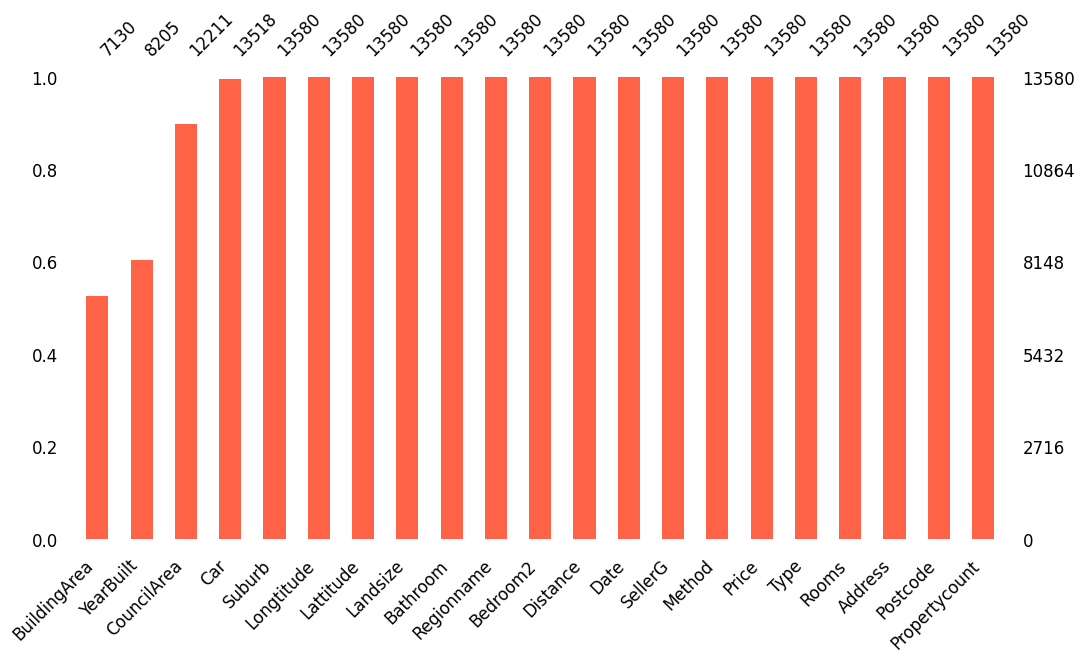

In [ ]:
import missingno as msno
msno.bar(melb_df,figsize=(12, 6), sort="ascending",fontsize=12, color='tomato')

Este gráfico nos muestra que columnas evitar, que son aquellas donde hay muchos datos faltantes. Por lo tanto se descartan: BuildingArea, YearBuilt, CouncilArea.
De las columnas restantes elegimos:
- cuatro variables que indiquen localizacion: PostCode, Suburb, Regionname y Distance
- tres  variables que indiquen información acerca de la construcción: Rooms, Car y type

En cuanto a los valores extremos, los set que podemos analizar para acotar son rooms, distance y car ya que los otros son categoricos.

In [ ]:
melb_df.Type.unique()

array(['h', 'u', 't'], dtype=object)

In [ ]:
melb_df.Rooms.unique()

array([ 2,  3,  4,  1,  6,  5,  8,  7, 10])

<Axes: >

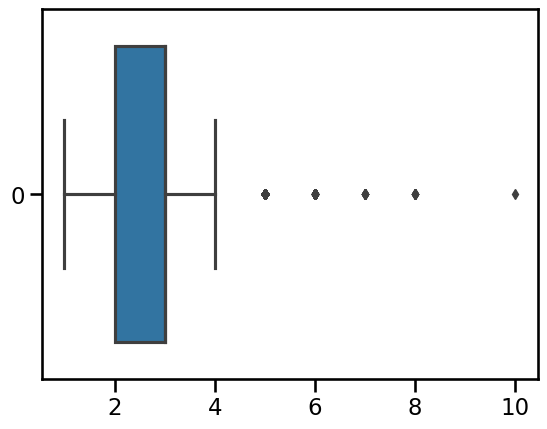

In [ ]:
sns.boxplot(melb_df["Rooms"], orient= "h"  )

In [ ]:
melb_df.Car.unique()

array([ 1.,  0.,  2.,  6.,  5.,  4.,  3.,  8.,  7.,  9., 10., nan])

<Axes: >

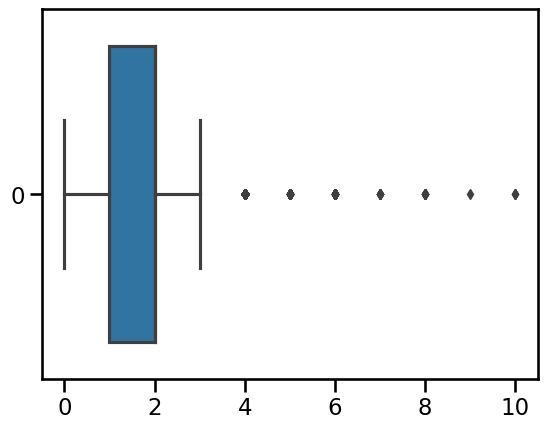

In [ ]:
sns.boxplot(melb_df["Car"], orient= "h"  )

<Axes: xlabel='Distance', ylabel='Count'>

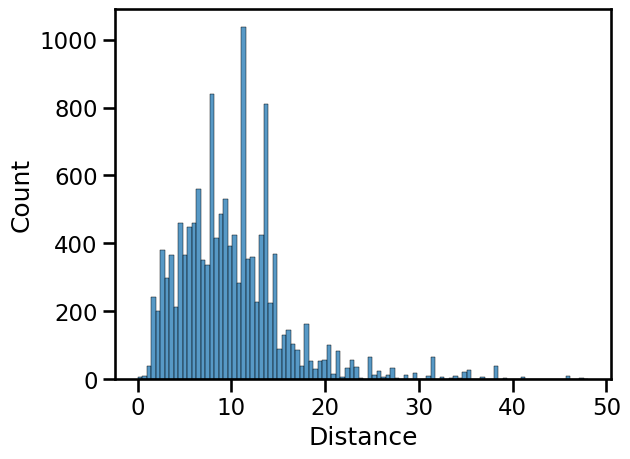

In [ ]:
sns.histplot(melb_df["Distance"], bins=100 )

<Axes: >

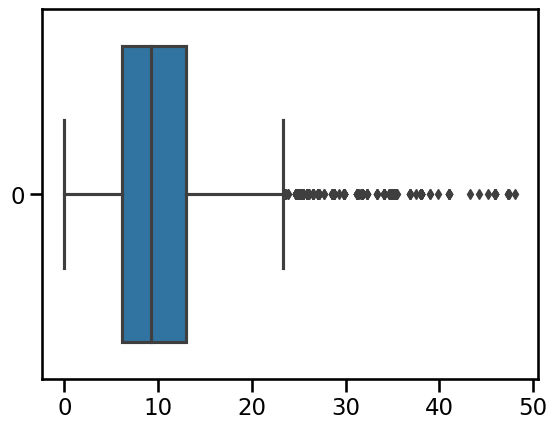

In [ ]:
sns.boxplot(melb_df["Distance"], orient= "h"  )

Con estos boxplot justificamos que valores extremos vamos a dejar afuera. Las casas con 5 habitaciones o más, las que tienen capacidad para 3 autos o más, ya que su frecuencia es unica y aquellas casas que estan a más de 22 dintancias.

In [ ]:
columnas_seleccionadas= ["Price", "Car", "Rooms", "Type", "Distance", "Suburb", "Regionname", "Postcode"]
melb_reducido_df = melb_df[columnas_seleccionadas]
melb_reducido_df = melb_reducido_df[ (melb_reducido_df['Rooms'] < 5) & (melb_reducido_df['Distance'] < 22 )& (melb_reducido_df['Car'] < 3)]
melb_reducido_df

,Price,Car,Rooms,Type,Distance,Suburb,Regionname,Postcode
0,1480000.0,1.0,2,h,2.5,Abbotsford,Northern Metropolitan,3067.0
1,1035000.0,0.0,2,h,2.5,Abbotsford,Northern Metropolitan,3067.0
2,1465000.0,0.0,3,h,2.5,Abbotsford,Northern Metropolitan,3067.0
3,850000.0,1.0,3,h,2.5,Abbotsford,Northern Metropolitan,3067.0
4,1600000.0,2.0,4,h,2.5,Abbotsford,Northern Metropolitan,3067.0
...,...,...,...,...,...,...,...,...
13573,635000.0,1.0,4,h,14.7,Werribee,Western Metropolitan,3030.0
13574,582000.0,2.0,3,h,16.5,Westmeadows,Northern Metropolitan,3049.0
13575,1245000.0,2.0,4,h,16.7,Wheelers Hill,South-Eastern Metropolitan,3150.0
13576,1031000.0,2.0,3,h,6.8,Williamstown,Western Metropolitan,3016.0


2. Agregar información adicional respectiva al entorno de una propiedad a partir del [conjunto de datos de AirBnB](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) utilizado en el práctico.
  1. Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna `price`, o aplicar múltiples transformaciones como la mediana o el mínimo.
  1. Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.
  2. Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. **NO** es necesario que realicen la implementación.

Pueden leer otras columnas del conjunto de AirBnB además de las que están en `interesting_cols`, si les parecen relevantes.

Para responder el punto 2.1 decidimos trabajar potencialmente con "price", 'weekly_price', 'monthly_price', "review_scores_location". Vamos a mirar primero si la cantidad de datos para cada una de estas columnas esta completa.

<Axes: >

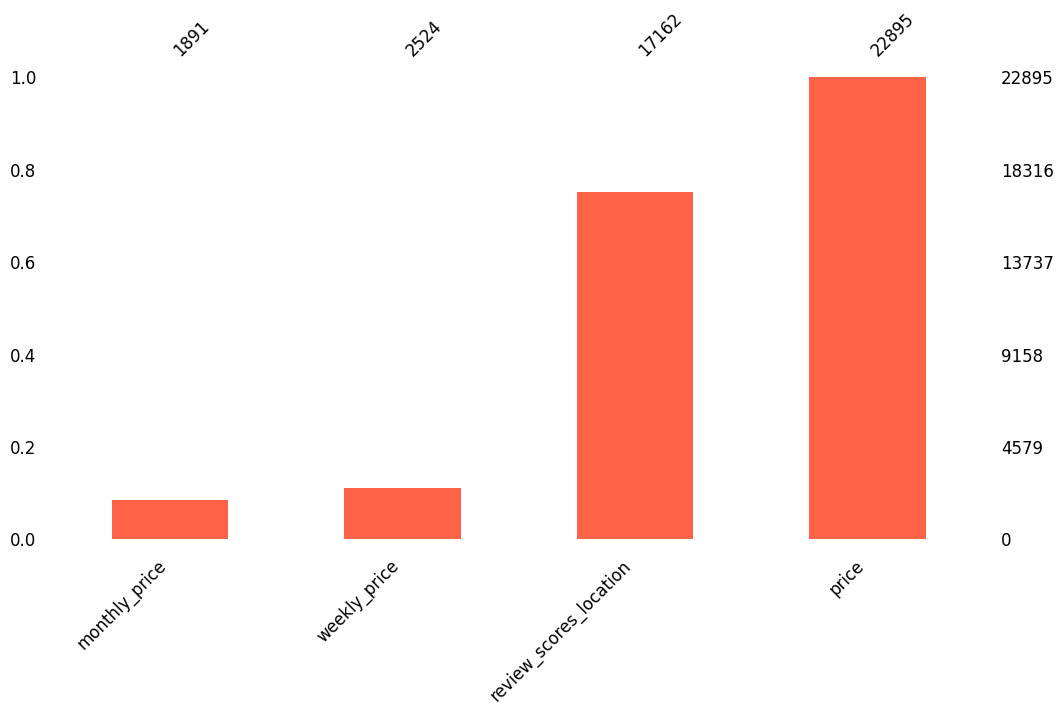

In [ ]:
msno.bar(airbnb_all_df[["price", 'weekly_price', 'monthly_price', "review_scores_location"]],figsize=(12, 6), sort="ascending",fontsize=12, color='tomato')

A partir de este grafico decidimos trabajar solo con price y review scores location. Esta ultima columna fue elegida porque creemos que puede aportar información interesante a la correlación precio/ubicación.

In [ ]:
airbnb_all_df['zipcode'] = pandas.to_numeric(airbnb_df.zipcode, errors='coerce') #Unimos float & int
relevant_cols = ['price', 'review_scores_location', "zipcode"]
airbnb_price_by_zipcode = airbnb_all_df[relevant_cols].groupby('zipcode')\
  .agg({'price': ['median', 'count'], 'review_scores_location': ['median', "count"]})\
  .reset_index()
# Flatten the two level columns
airbnb_price_by_zipcode.columns = [
  ' '.join(col).strip()
  for col in airbnb_price_by_zipcode.columns.values]
# Rename columns
airbnb_price_by_zipcode = airbnb_price_by_zipcode.rename(
    columns={'price median': 'airbnb_price_median',
             'price count': 'airbnb_record_count',
             'review_scores_location median': 'review_scores_location_median',
             'review_scores_location count': 'review_scores_location_count'}
)
airbnb_price_by_zipcode

,zipcode,airbnb_price_median,airbnb_record_count,review_scores_location_median,review_scores_location_count
0,2010.0,40.0,1,NaN,0
1,2134.0,50.0,1,NaN,0
2,2582.0,104.0,1,NaN,0
3,3000.0,129.0,3367,10.0,2764
4,3001.0,132.5,2,9.0,2
...,...,...,...,...,...
242,7367.0,230.0,1,NaN,0
243,8938.0,296.0,1,NaN,0
244,9004.0,226.0,1,NaN,0
245,9540.0,245.0,1,NaN,0


Vamos a poner como límite inferior la existencia de 10 registro Airbnb en un zipcode para tenerlo en cuenta. De esta forma pasamos de tener 247 filas a tener 182 pero son mas representativas.

In [ ]:
airbnb_price_by_zipcode_filt = airbnb_price_by_zipcode[airbnb_price_by_zipcode.airbnb_record_count >= 10]
airbnb_price_by_zipcode_filt

,zipcode,airbnb_price_median,airbnb_record_count,review_scores_location_median,review_scores_location_count
3,3000.0,129.0,3367,10.0,2764
5,3002.0,130.0,197,10.0,146
6,3003.0,120.0,267,10.0,208
7,3004.0,130.0,728,10.0,556
8,3006.0,150.0,1268,10.0,959
...,...,...,...,...,...
219,3806.0,84.0,33,10.0,26
222,3809.0,64.5,14,10.0,9
223,3810.0,84.0,22,10.0,17
228,3911.0,225.0,10,10.0,8


Por ultimo realizamos el merge y luego algunos gráficos para ver que tipo de predicción podríamos hacer a priori para la predicción del precio de una vivienda.

In [ ]:
merged_sales_df = melb_reducido_df.merge(
    airbnb_price_by_zipcode_filt, how='left',
    left_on='Postcode', right_on='zipcode'
)
merged_sales_df

,Price,Car,Rooms,Type,Distance,Suburb,Regionname,Postcode,zipcode,airbnb_price_median,airbnb_record_count,review_scores_location_median,review_scores_location_count
0,1480000.0,1.0,2,h,2.5,Abbotsford,Northern Metropolitan,3067.0,3067.0,100.0,258.0,10.0,208.0
1,1035000.0,0.0,2,h,2.5,Abbotsford,Northern Metropolitan,3067.0,3067.0,100.0,258.0,10.0,208.0
2,1465000.0,0.0,3,h,2.5,Abbotsford,Northern Metropolitan,3067.0,3067.0,100.0,258.0,10.0,208.0
3,850000.0,1.0,3,h,2.5,Abbotsford,Northern Metropolitan,3067.0,3067.0,100.0,258.0,10.0,208.0
4,1600000.0,2.0,4,h,2.5,Abbotsford,Northern Metropolitan,3067.0,3067.0,100.0,258.0,10.0,208.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11209,635000.0,1.0,4,h,14.7,Werribee,Western Metropolitan,3030.0,3030.0,68.0,258.0,9.0,178.0
11210,582000.0,2.0,3,h,16.5,Westmeadows,Northern Metropolitan,3049.0,3049.0,65.0,21.0,10.0,20.0
11211,1245000.0,2.0,4,h,16.7,Wheelers Hill,South-Eastern Metropolitan,3150.0,3150.0,80.0,189.0,10.0,133.0
11212,1031000.0,2.0,3,h,6.8,Williamstown,Western Metropolitan,3016.0,3016.0,180.0,74.0,10.0,46.0


<Axes: xlabel='Distance', ylabel='Price'>

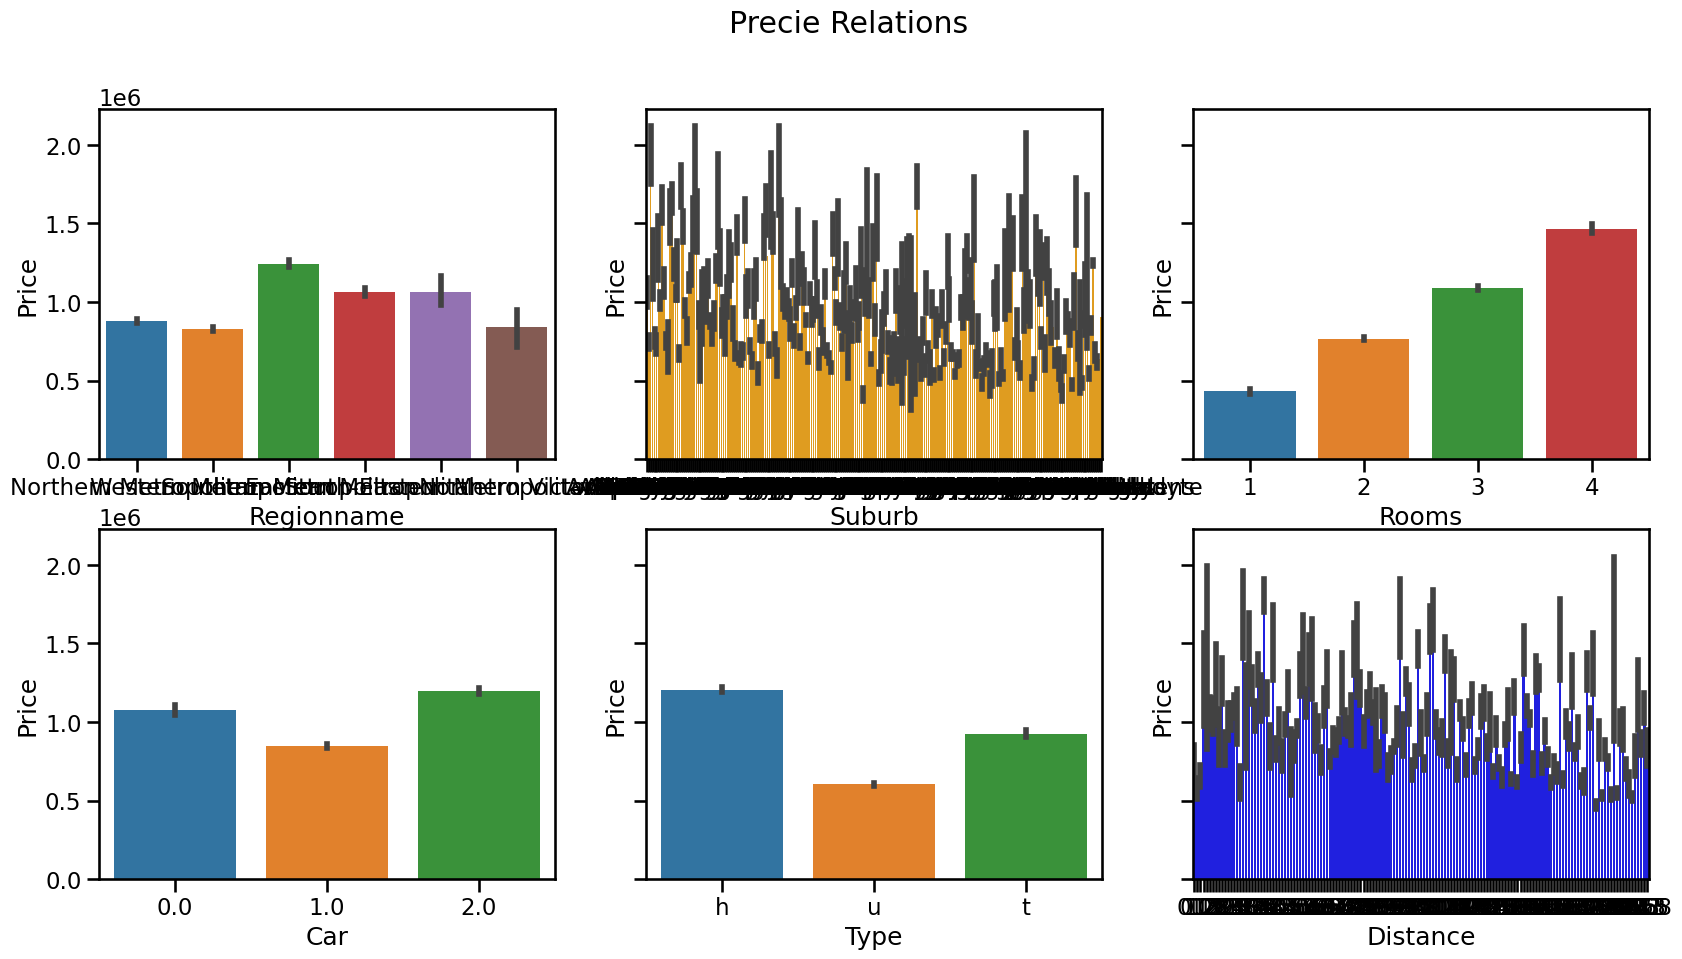

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
fig.suptitle('Precie Relations')

# Rionname
sns.barplot(ax=axes[0,0], x=merged_sales_df['Regionname'], y=merged_sales_df['Price'])
#axes[0,0].tick_params(labelrotation=90)

# Suburb
sns.barplot(ax=axes[0,1], x=merged_sales_df['Suburb'], y=merged_sales_df['Price'],  color='orange')
#axes[0,1].tick_params(labelrotation=90)
# Rooms
sns.barplot(ax=axes[0,2], x=merged_sales_df['Rooms'], y=merged_sales_df['Price'])

# Car
sns.barplot(ax=axes[1,0], x=merged_sales_df['Car'], y=merged_sales_df['Price'])

# Type
sns.barplot(ax=axes[1,1], x=merged_sales_df['Type'], y=merged_sales_df['Price'])

# Distance
sns.barplot(ax=axes[1,2], x=merged_sales_df['Distance'], y=merged_sales_df['Price'],  color='blue')





En base a estos gráficos podemos ver que la region no es tan influyente en el precio. En cuanto a la variacion segun el "suburbio" y según la "distancia" podemos ver que los datos estan muy desagregados. En este caso podriamos hacer agrupamientos por zonas para ver si hay alguna información más certera. Una buena prediccion la permite el numero de habitaciones, ya que se ve que claramente es mayor el precio a mayor cantidad de habitaciones, mientras que el número de autos no permite una predicción. El tipo de vivienda tambien determina el precio siendo las viviendas tipo unidad/duplex la de menor costo.

Type: h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse;

Del dataset de Airbnb, decidimos seleccionar las variables "price" y "review_scores_location". En ambos casos, vamos a trabajar con la mediana por zipcode ya que este valor nos parece el más representativo, menos influenciado por valores extremos.

Para combinar los datos a través de otra variable, debemos tener en cuenta las que hacen referencia a la locación de los inmuebles. En este sentido podríamos pensar en utilizar: 'street', 'neighborhood', 'city', 'suburb' o 'state'. De estas variables, creemos que 'state' es demasiado general para agrupar la información, mientras que 'street' y 'suburb' son muy específicos (hay una gran cantidad de valores que pueden tomar esas variables). En ese sentido, creemos que 'neighborhood' y 'city' son variables óptimas. Sin embargo, para ambas, necesitamos de un especialista que genere la variable 'neighborhood' en la base de Kaggle ya que no existe y que complete la variable 'city' ('CouncilArea' en Kaggle) a partir de las direcciones de las propiedades

## Ejercicio 3:

Crear y guardar un nuevo conjunto de datos con todas las transformaciones realizadas anteriormente.

In [ ]:
merge_sale_limpio = merged_sales_df.drop('zipcode', axis=1) #Se elimina la colummna repetida
merge_sale_limpio

,Price,Car,Rooms,Type,Distance,Suburb,Regionname,Postcode,airbnb_price_median,airbnb_record_count,review_scores_location_median,review_scores_location_count
0,1480000.0,1.0,2,h,2.5,Abbotsford,Northern Metropolitan,3067.0,100.0,258.0,10.0,208.0
1,1035000.0,0.0,2,h,2.5,Abbotsford,Northern Metropolitan,3067.0,100.0,258.0,10.0,208.0
2,1465000.0,0.0,3,h,2.5,Abbotsford,Northern Metropolitan,3067.0,100.0,258.0,10.0,208.0
3,850000.0,1.0,3,h,2.5,Abbotsford,Northern Metropolitan,3067.0,100.0,258.0,10.0,208.0
4,1600000.0,2.0,4,h,2.5,Abbotsford,Northern Metropolitan,3067.0,100.0,258.0,10.0,208.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11209,635000.0,1.0,4,h,14.7,Werribee,Western Metropolitan,3030.0,68.0,258.0,9.0,178.0
11210,582000.0,2.0,3,h,16.5,Westmeadows,Northern Metropolitan,3049.0,65.0,21.0,10.0,20.0
11211,1245000.0,2.0,4,h,16.7,Wheelers Hill,South-Eastern Metropolitan,3150.0,80.0,189.0,10.0,133.0
11212,1031000.0,2.0,3,h,6.8,Williamstown,Western Metropolitan,3016.0,180.0,74.0,10.0,46.0


## Ejercicios opcionales:

1. Armar un script en python (archivo .py) [ETL](https://towardsdatascience.com/what-to-log-from-python-etl-pipelines-9e0cfe29950e) que corra los pasos de extraccion, transformacion y carga, armando una funcion para cada etapa del proceso y luego un main que corra todos los pasos requeridos.

Para resolver este ejercicio utilizaremos los desarrollos del código realizados en el punto 1 de este entregable. Emularemos su funcionamiento pero encapsulado en funciones como pipeline ETL

In [ ]:
#Importamos la librería necesaria para guardar los logs
import logging

#La seteamos en debug para que registre todo lo que va sucediendo
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [ ]:
#Defino variables globales que voy a utilizar en main y Airflow
INTERESTING_COLS = ['description', 'neighborhood_overview','street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode','price', 'weekly_price', 'monthly_price','latitude', 'longitude']

MELB_CSV = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv'

AIRBNB_CSV = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv'


In [ ]:
#Creación y conexión a la DB en SQLite
def connection_to_db():
  try:
    new_engine = create_engine('sqlite:///melbourne_ETL.db')
    logger.info('Conexión a la DB exitosa')
    return new_engine

  except Exception as e:
    #Cómo es una instancia de debug, vamos a capturar cualquier excepción en e, porque no sabemos que tipo de alertas pueden aparecer
    #Cuando se vaya afinando, podemos ir creando excepciones específicas como ValueError o KeyError
    logger.error(e)

In [ ]:
#A partir de una url donde se almacena un csv, lo convertimos a pandas y devolvemos el DF
def extract_from_source(csv_url, specific_columns=False):
  try:
    #Utilizamos el parámetro specific_columns en el caso de que queramos el DF solo con ciertas columnas
    if specific_columns:
      df = pandas.read_csv(csv_url, usecols=specific_columns)
      logger.info('CSV con specific_columns leído correctamente')
    else:
      df = pandas.read_csv(csv_url)
      logger.info('CSV leído correctamente')

    return df
  except Exception as e:
    logger.error(e)

In [ ]:
def merge_transformation(first_df,first_merge_column, second_df, second_merge_column):
  try:
        #Revisamos que tengan las columnas por las que queremos mergear
        if first_merge_column not in first_df.columns:
            logger.error(f"El DataFrame '{first_df}' no tiene la columna '{first_merge_column}'")

        if second_merge_column not in second_df.columns:
            logger.error(f"El DataFrame '{second_df}' no tiene la columna '{second_merge_column}'")

        # Agregamos sufijos a los nombres para evitar errores por repetición
        first_df = first_df.add_suffix('_first')
        second_df = second_df.add_suffix('_second')

        #Cómo tenemos nuevos sufijos hay que reformar los nombres de las columnas por las que mergeamos
        first_merge_column = first_merge_column+'_first'
        second_merge_column = second_merge_column+'_second'

        # Convertimos las columnas de unión al mismo tipo de datos
        first_df[first_merge_column] = first_df[first_merge_column].astype(str)
        second_df[second_merge_column] = second_df[second_merge_column].astype(str)

        #Hacemos el merge
        merge_both_dfs = first_df.merge(second_df, left_on=first_merge_column, right_on=second_merge_column, how='left')
        return merge_both_dfs

  except Exception as e:
    logger.error(e)

In [ ]:
def load(df_to_save, new_table_name, engine):
  try:
    df_to_save.to_sql(f'{new_table_name}', con=engine, if_exists='replace')
    return True

  except Exception as e:
    logger.error(e)


In [ ]:
  def main():
    logger.info('Comienza la ejecución de main')
    engine = connection_to_db()

    df_melb_csv = extract_from_source(MELB_CSV)
    df_airbnb_csv = extract_from_source(AIRBNB_CSV, specific_columns=INTERESTING_COLS)

    df_transformation = merge_transformation(df_melb_csv, 'Postcode', df_airbnb_csv, 'zipcode')

    load_new_information = load(df_transformation, 'MELB_AND_AIRBNB', engine)

    if load_new_information:
      logger.info('El proceso se ejecutó correctamente')

  if __name__ == "__main__":
      main()


INFO:__main__:Comienza la ejecución de main
INFO:__main__:Conexión a la DB exitosa
INFO:__main__:CSV leído correctamente
<ipython-input-44-3c965967d16c>:6: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pandas.read_csv(csv_url, usecols=specific_columns)
INFO:__main__:CSV con specific_columns leído correctamente
INFO:__main__:El proceso se ejecutó correctamente


2. Armar un DAG en Apache Airflow que corra el ETL. (https://airflow.apache.org/docs/apache-airflow/stable/tutorial.html)

Según lo que comentó el profesor en clase, por las limitaciones de Google Colab, este DAG no correrá. De todas maneras, queda planteado para practicar su implementación

In [ ]:
# ejemplo de DAG en Airflow
from airflow import DAG
from airflow.operators.python_operator import PythonOperator
from datetime import datetime, timedelta

# Definimos los argumentos del DAG
default_args = {
    'owner': 'grupo_18',
    'start_date': datetime(2023, 5, 30),
    'retries': 2,
    'retry_delay': timedelta(minutes=5),
}

with DAG(
    'dag_test',
    default_args=default_args,
    description='DAG',
    schedule_interval=timedelta(hours=1),
) as dag:

    # Definimos el operador PythonOperator para cada tarea:
      #task_id será el nombre con el que podemos referencias la tarea
      #python_callable es la función a la que se llama en esa tarea -de las funciones que definimos más arriba-
      #op_kwargs se usa para cuando tengamos que pasar argumentos a esas funciones.
        #al usar task_instance.xcom_pull estamos referenciando el resultado de otra tarea.
        #Esto lo hacemos porque necesitamos pasar como argumento el resultado de la ejecución de otra variable.
    connection_task = PythonOperator(
        task_id='connection_task',
        python_callable=connection_to_db,
        dag=dag
    )

    melb_extraction_task = PythonOperator(
        task_id='melb_extraction_task',
        python_callable=extract_from_source,
        op_kwargs={'csv_url': MELB_CSV},
        dag=dag
    )

    airbnb_extraction_task = PythonOperator(
        task_id='airbnb_extraction_task',
        python_callable=extract_from_source,
        op_kwargs={'csv_url': AIRBNB_CSV, 'specific_columns': INTERESTING_COLS},
        dag=dag
    )

    transformation_task = PythonOperator(
        task_id='transformation_task',
        python_callable=merge_transformation,
        op_kwargs={'first_df': "{{ task_instance.xcom_pull(task_ids='melb_extraction_task') }}",
                   'first_merge_column': 'Postcode',
                   'second_df': "{{ task_instance.xcom_pull(task_ids='airbnb_extraction_task') }}",
                   'second_merge_column': 'zipcode'},
        dag=dag
    )

    load_task = PythonOperator(
        task_id='load_task',
        python_callable=load,
        op_kwargs={'df_to_save': "{{ task_instance.xcom_pull(task_ids='transformation_task') }}",
                   'new_table_name': 'MELB_AND_AIRBNB',
                   'engine': "{{ task_instance.xcom_pull(task_ids='connection_task') }}"},
        dag=dag
    )

    #Genereamos el orden de ejecución y las dependencias necesarias
    #Primero extraemos la información de los dos csv, luego los transformamos.
    #Si todo eso salió bien, nos conectamos a la BD y cargamos la nueva información
    melb_extraction_task >> airbnb_extraction_task >> transformation_task >> connection_task >> load_task


ModuleNotFoundError: ignored